# Grey-box identification of heat transfer dynamics

Last update: 27-07-2023

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [50]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [51]:
using Revise
using DifferentialEquations
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using MAT
using JLD2
using Optim
using Polynomials
using Random
using RxInfer
using Plots; 
default(label="", linewidth=3, margin=15Plots.pt)

include("../util/discretization.jl");
include("../util/heat-input.jl");

## Data simulation

In [376]:
# Time parameters
T = 1000
Δt = 1.0
tsteps = range(1e-3, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 10.
true_k23 = 10.
true_h_a = 2.0
true_τ_a = 21.
true_R   = 1e-3*diagm(ones(3))

# Input heat parameters
true_b = [100.0, 0., 0.]

3-element Vector{Float64}:
 100.0
   0.0
   0.0

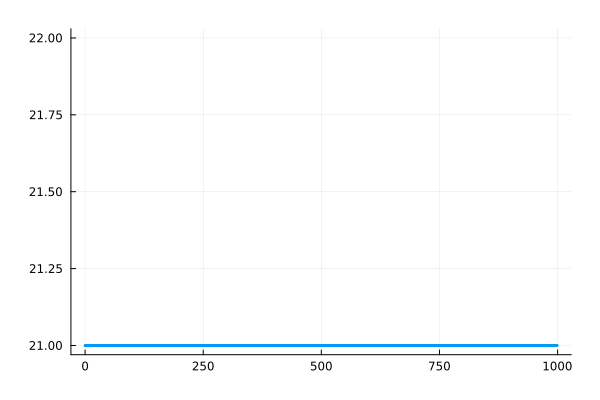

In [377]:
function T_a(t::Float64, t_on::Float64, t_off::Float64)
    return 21 - 5 ./(1+exp(-0.04*(t - t_on))) * exp(-0.05*(t - t_off))./(1+exp(-0.05*(t - t_off)))
end

function T_a(t::Float64)
    return true_τ_a
end

plot(tsteps, T_a.(tsteps))

In [378]:
# Temperature inputs
τr = range(10, stop=40, step=0.1)
NN = length(τr)

# Kernel hyperparameters
l_true = 1e4
λ_true = sqrt(3)/l_true
γ_true = 1e3

# Kernel
κ(τ,τ_prime) = γ_true^2 .*exp.(-λ_true.*abs.(τ - τ_prime))
K = zeros(NN,NN)
for ii in 1:NN
    for jj in 1:NN
        K[ii,jj] = κ(τr[ii], τr[jj])
    end
end

# Inverse of kernel
Ki = inv(K + 0.0*diagm(ones(NN)))

# Generate targets for Gaussian Process
r(z,i,τ_a) = (τ_a - z)^3 ./ 100
targets1 = r.(τr, 1, true_τ_a) 
targets2 = r.(τr, 2, true_τ_a) 
targets3 = r.(τr, 3, true_τ_a)  

# GP Predictive distribution
pred_mean_block1(τ) = dot(κ.(τ,τr), Ki*targets1)
pred_mean_block2(τ) = dot(κ.(τ,τr), Ki*targets2)
pred_mean_block3(τ) = dot(κ.(τ,τr), Ki*targets3)

pred_mean_block3 (generic function with 1 method)

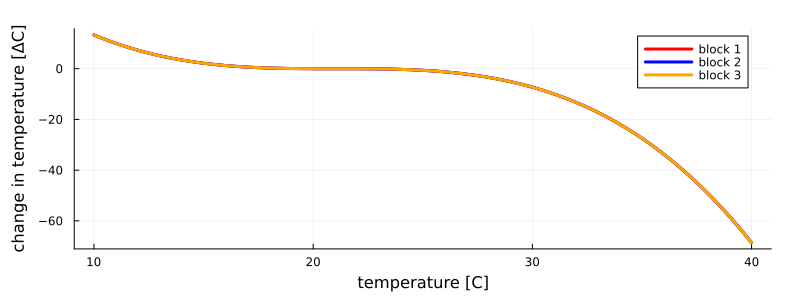

In [379]:
# Simulate nonlinear convection function
dτr1 = pred_mean_block1.(τr)
dτr2 = pred_mean_block2.(τr)
dτr3 = pred_mean_block3.(τr)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr1, color="red", label="block 1")
plot!(τr, dτr2, color="blue", label="block 2")
plot!(τr, dτr3, color="orange", label="block 3")

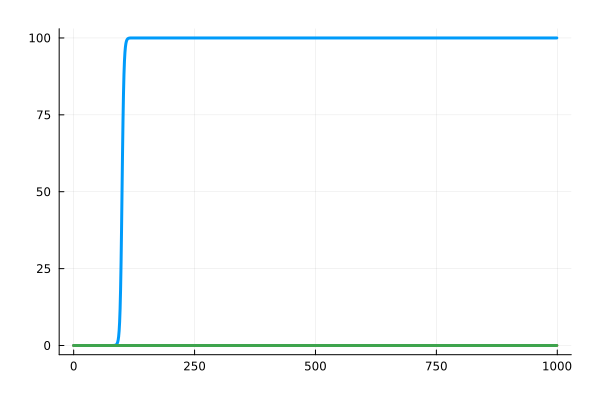

In [380]:
t_onset = 100.
t_offset = 300.
β = 0.5

# Generate functions
# u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
# u2(t) = u.(t, b=true_b[2], t_on=t_onset, t_off=t_offset, i=2, β1=β)
# u3(t) = u.(t, b=true_b[3], t_on=t_onset, t_off=t_offset, i=3, β1=β)
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)
# inputs = true_b*ones(1,T)

plot(tsteps, inputs')

In [381]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (T_a(t) - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (T_a(t) - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (T_a(t) - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += r(z[1],1,T_a(t)) / mcp_1
    dz[2] += r(z[2],2,T_a(t)) / mcp_2
    dz[3] += r(z[3],3,T_a(t)) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

In [382]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [21., 21., 21.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

3×1000 Matrix{Float64}:
 21.0  21.0  21.0  21.0  21.0  21.0  …  34.718   34.7187  34.7195  34.7202
 21.0  21.0  21.0  21.0  21.0  21.0     30.1194  30.1203  30.1212  30.1221
 21.0  21.0  21.0  21.0  21.0  21.0     28.196   28.1972  28.1983  28.1994

In [383]:
# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

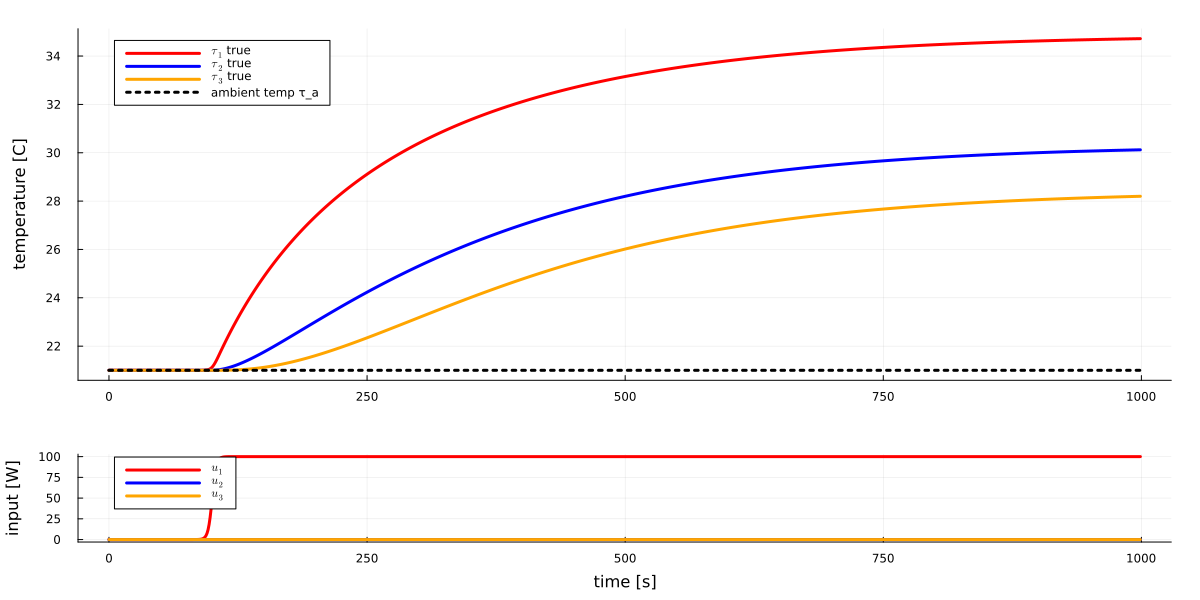

In [384]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
# scatter!(tsteps, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
plot!(tsteps, T_a.(tsteps), color="black", linewidth=3, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [W]")
plot!(tsteps, inputs', linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

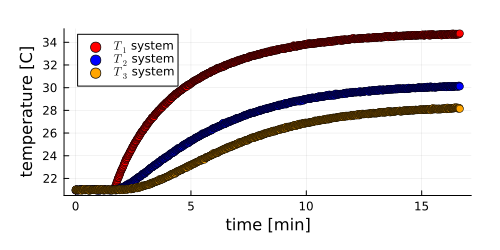

In [385]:
plot(tsteps ./ 60,
     states';
     legend = true, 
     linewidth=4,
    #  title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
#      labels = [L"$T_1$ identified" L"$T_2$ identified" L"$T_3$ identified"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,250)
)
scatter!(tsteps ./ 60, 
      transpose(measurements), 
      linewidth=4,
      alpha = 1.,
      markercolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$T_1$ system" L"$T_2$ system" L"$T_3$ system"],
)


In [386]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

## GP-augmented state-space model

### Matern-1/2 GP in state-space form
Suppose a function $h(x)$ follows a zero-mean Gaussian Process

$$\begin{aligned}
h(x) \sim \mathcal{GP}(0, k(x,x')) \, .
\end{aligned}$$

The GP can be written as the following differential equation ([Hartikainen, 2013)](https://aaltodoc.aalto.fi/bitstream/handle/123456789/7579/isbn9789526049847.pdf?sequence=1&isAllowed=y)):

$$\begin{align}
\dot{h} = F_h h + L v \, ,
\end{align}$$

with $h$ being states, $F_h$ a state transition matrix and $v$ a white noise process. The Matern GP has a stationary covariance function, defined as:

$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$

where $\sigma^2$ is a scale hyperparameter, $l$ a characteristic length-scale, $\nu$ the smoothness hyperparameter, and $K_\nu(.)$ is a modified Bessel function of the second kind. 

Matern-1/2 refers to $\nu=1/2$. The matrices for the state space model are computed as follows:

$$\begin{aligned}
\mathbf{F}_h = -\lambda,\quad \quad \mathbf{L} = 1, \quad \quad \mathbf{P}_\infty = \sigma^2  ,\quad \quad  Q_c = 2\lambda\sigma^2
\end{aligned}$$ 

where $\lambda = \frac{\sqrt{3}}{l} $.

### Augmented state-space model

The original state-space model (see top) is:

$$\begin{aligned}
\underbrace{\begin{bmatrix} \dot{\tau}_1 \\ \vdots \\ \dot{\tau}_3 \end{bmatrix}}_{\dot{z}} = \underbrace{\begin{bmatrix} \frac{-k_{12} - h_a a_1}{m_1 c_{p,1}} & \frac{k_{12}}{m_1 c_{p,1}} & 0 \\
\frac{k_{12}}{m_2 c_{p,2}} & \frac{-k_{12} - k_{23} - h_a a_2}{m_2 c_{p,2}} & \frac{k_{23}}{m_2 c_{p,2}} \\
 0 & \frac{k_{23}}{m_3 c_{p,3}} & \frac{-k_{23} - h_a a_3}{m_3 c_{p,3}} \end{bmatrix}}_{F} \underbrace{\begin{bmatrix} \tau_1 \\ \vdots \\ \tau_3 \end{bmatrix}}_{z} + \underbrace{\begin{bmatrix} \frac{h_a a_1}{m_1 c_{p,1}} & \frac{1}{m_1 c_{p,1}} & 0 & 0 \\ \frac{h_a a_2}{m_2 c_{p,2}} & 0 & \frac{1}{m_2 c_{p,2}} & 0 \\ \frac{h_a a_3}{m_3 c_{p,3}} & 0 & 0 & \frac{1}{m_3 c_{p,3}} \end{bmatrix}}_{G} \underbrace{\begin{bmatrix} \tau_a \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}}_{u} + M^{-1}r(z) \, 
\end{aligned}$$

Since $r(z)$ is vector-valued, we need multiple GP functions:

$$\begin{aligned}
r(z) \approx h = \begin{bmatrix} h^{(1)} \\ h^{(2)} \\ h^{(3)} \end{bmatrix} \, .
\end{aligned}$$

Augmenting the state-space model with $h$ as described above, gives:

$$\begin{aligned}
\begin{bmatrix} \dot{z} \\ \dot{h} \end{bmatrix} = \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \begin{bmatrix} z \\ h \end{bmatrix} +  \begin{bmatrix} G \\ 0 \end{bmatrix} u + \begin{bmatrix} 0 \\ L \end{bmatrix} w \, .
\end{aligned}$$

After discretization, we get:

$$\begin{aligned}
x_{k+1} = A x_k + B u_k + w_k\, , \quad \text{with}\ w_k \sim \mathcal{N}(0, Q) \, ,
\end{aligned}$$

where $x_k = \begin{bmatrix} z_k \\ h_k \end{bmatrix}$ and

$$\begin{aligned}
    A = \exp\big(\Delta t \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \big) \, , \quad B = \begin{bmatrix} \Delta t G \\ 0 \end{bmatrix} \, , \quad Q = \int_0^{\Delta t} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix}t) \begin{bmatrix} 0 \\ L \end{bmatrix} Q_c \begin{bmatrix} 0 \\ L \end{bmatrix}^{\top} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} t)^{\top} dt \, .
\end{aligned}$$

In [387]:
@model function SSM(A, B, C, Q, R, m0, S0; T=1)
    
    x = randomvar(T)
    u = datavar(Vector{Float64}, T)
    y = datavar(Vector{Float64}, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [388]:
Dx = 6
Dt = 3
Dh = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dh))]

λ_star = λ_true
γ_star = γ_true

A  = exp([F                              inv(M);
          zeros(Dh,Dh)  diagm(-λ_star*ones(Dh))]*Δt)
B  = [G; zeros(Dh,Du)]*Δt
C  = [diagm(ones(Dy)) zeros(Dy,Dx-Dy)]
Q  = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)
R  = true_R*diagm(ones(Dy))

m0 = [τ_0; zeros(Dh)]
S0 = diagm([1e-3ones(Dy); γ_star^2*ones(Dh)])

results = infer(
    model       = SSM(A, B, C, Q, R, m0, S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-344.757]


In [314]:
pg = GammaShapeRate(1e1, 1e-1)
[mean(pg) var(pg)]

1×2 Matrix{Float64}:
 100.0  1000.0

In [315]:
function J(hparams::AbstractVector)

    "Prior distribution"

    prior1 = -Distributions.logpdf(GammaShapeRate(1e3, 1e0), hparams[1])
    prior2 = -Distributions.logpdf(GammaShapeRate(1e1, 1e-1), hparams[2])

    "Likelihood"

    λ = sqrt(3)/hparams[1]
    A = [inv(M)*(K-true_h_a*diagm(An))              inv(M);
         zeros(Dh,Dh)                   -λ*diagm(ones(Dh))]*Δt + diagm(ones(Dx))
        
    Q = analyticQ(inv(M), λ, hparams[2], Δt=Δt)
        
    m0 = [τ_0; zeros(3)]
    S0 = diagm([1e-8ones(3); hparams[2]^2*ones(3)])

    results = infer(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

    # Total cost
    return results.free_energy[end] #+ prior1 + prior2
end

ops = Optim.Options(g_tol=1e-8, time_limit=300, show_every=1)
res = optimize(J, 1e-2, 1e8, [100., 10.], Fminbox(LBFGS()), ops; autodiff=:forward)
# res = optimize(J, [1., 1.], LBFGS(), ops; autodiff=:forward)
l_star, γ_star = Optim.minimizer(res)

InterruptException: InterruptException:

In [237]:
λ_star = sqrt(3)/l_star
A = exp([inv(M)*(K-true_h_a*diagm(An))                  inv(M);
         zeros(Dh,Dh)                  -λ_star*diagm(ones(Dh))]*Δt)
Q = analyticQ(inv(M),λ_star, γ_star, Δt=Δt)

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dt); γ_star^2*ones(Dh)])

results = infer(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-3009.69]


In [238]:
H = ForwardDiff.jacobian(x -> ForwardDiff.gradient(J, x), [l_star, γ_star])
post_S = inv(Hermitian((H + H')/2))
post_hparams = MvNormal([l_star, γ_star], post_S)

FullNormal(
dim: 2
μ: [25216.696045178574, 124.82074474622942]
Σ: [4.0605721497243905e8 999930.9760746162; 999930.9760746162 2474.9409411933775]
)


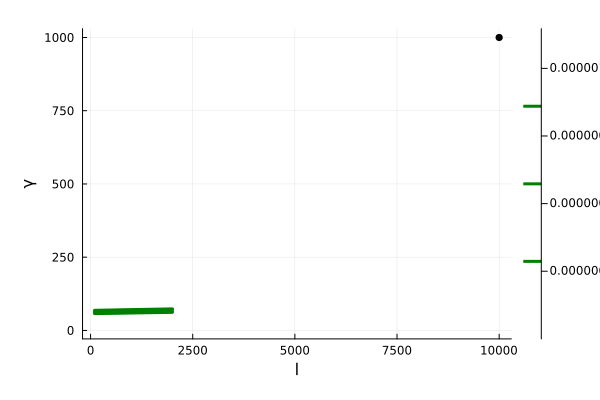

In [239]:
lr = range(100, stop=2000, length=300)
γr = range(1, stop=100, length=300)

plot(xlabel="l", ylabel="γ")
contour!(lr, γr, (x,y) -> pdf(post_hparams, [x,y]), color="green", levels=3)
scatter!([l_true], [γ_true], color="black")

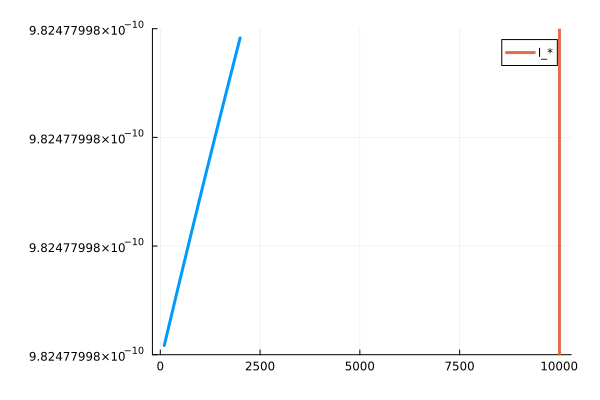

In [240]:
post1 = Normal(l_star, post_S[1,1])

plot(lr, pdf.(post1, lr))
vline!([l_true], label="l_*")

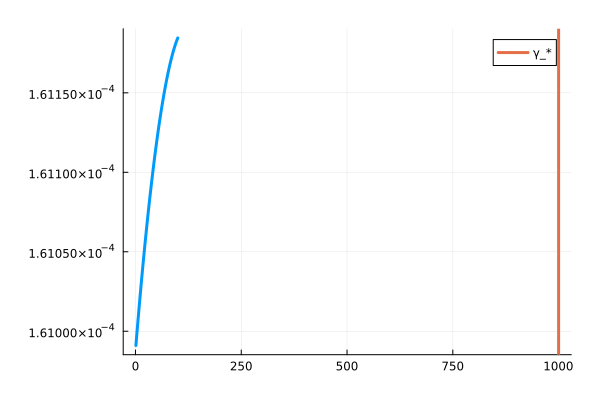

In [241]:
post2 = Normal(γ_star, post_S[2,2])
plot(γr, pdf.(post2, γr))
vline!([γ_true], label="γ_*")

In [389]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

6×1000 Matrix{Float64}:
 20.9375     20.992       21.046      …   34.7331    34.7246    34.7792
 20.9582     20.9951      21.0357         30.1872    30.1425    30.1074
 20.996      21.0112      21.0309         28.2037    28.2057    28.1388
 -0.0984967   0.00582375  -0.0517983     -23.3986   -23.2638   -23.184
 -0.149797   -0.0812129   -0.12841        -7.83448   -8.00205   -8.05285
 -0.171259   -0.183067    -0.248832   …   -6.96271   -7.14993   -7.2459

In [390]:
SMSE_GPSSM = mean((fitx_m[1:3,:] - states).^2)
println("MSE states and fit: $SMSE_GPSSM")

MSE states and fit: 0.0009763869379249633


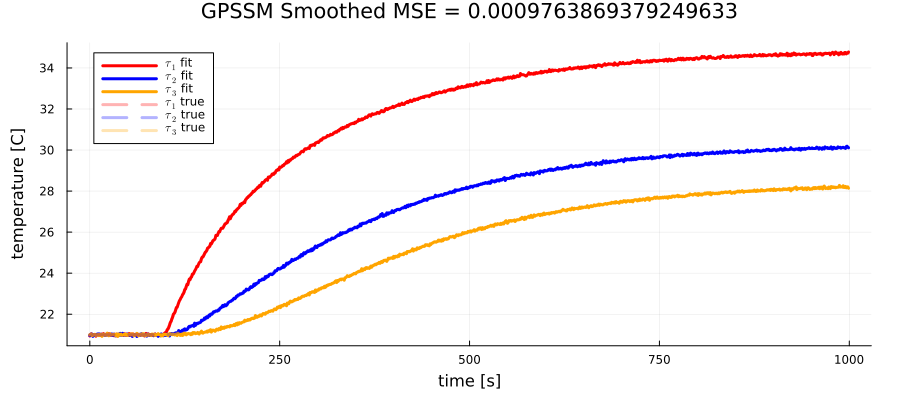

In [391]:
plot(tsteps,
     fitx_m[1:3,:]';
     ribbon=sqrt.(fitx_v[1:3,:])',
     legend = true, 
     title="GPSSM Smoothed MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ fit" L"$τ_2$ fit" L"$τ_3$ fit"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps, 
      transpose(states), 
      alpha = 0.3,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


### Gaussian process fits over time

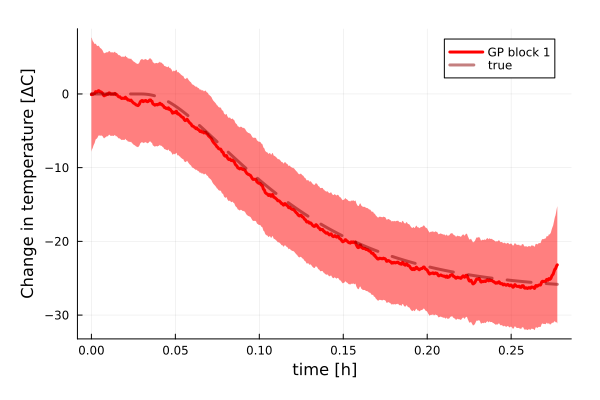

In [392]:
plot(tsteps ./ 3600,
     fitx_m[4,:];
     ribbon=sqrt.(fitx_v[4,:])./10,
     legend = true, 
     color = "red",
     labels = "GP block 1",
     xlabel = "time [h]", 
     ylabel = "Change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps ./ 3600, pred_mean_block1.(states[1,:]), color="darkred", alpha=0.5, linestyle=:dash, label="true")
# plot!(tsteps, r.(states[1,:],1,true_τ_a), color="darkred", alpha=0.5, linestyle=:dash, label="true")

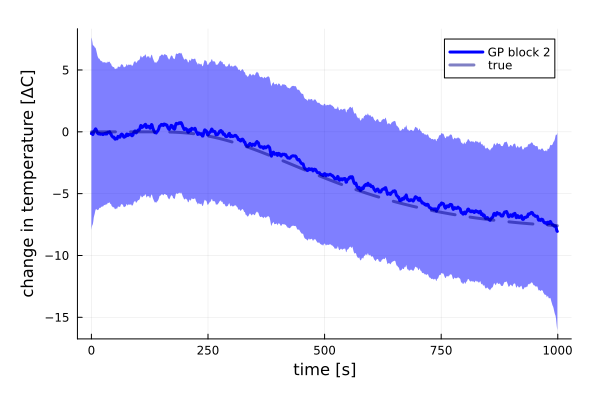

In [393]:
plot(tsteps,
     fitx_m[5,:],
     ribbon=sqrt.(fitx_v[5,:])./10,
     legend = true, 
     color = "blue",
     labels = "GP block 2",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, pred_mean_block2.(states[2,:]), color="darkblue", alpha=0.5, linestyle=:dash, label="true")

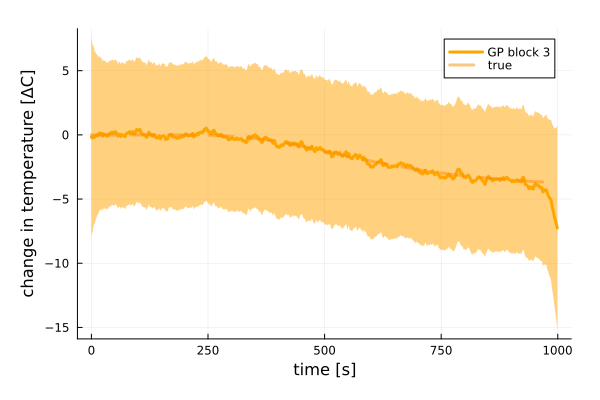

In [394]:
plot(tsteps,
     fitx_m[6,:],
     ribbon=sqrt.(fitx_v[6,:]) ./ 10,
     legend = true, 
     color = "orange",
     labels = "GP block 3",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, pred_mean_block3.(states[3,:]), color="darkorange", alpha=0.5, linestyle=:dash, label="true")

### Extract nonlinearity

In [395]:
n_samples = 5
deg = 3

yls = [-0.5, 0.05]
xls = [285, 296]

samples_z1 = cat([rand(Normal(fitx_m[1,k],sqrt.(fitx_v[1,k])), n_samples) for k in 1:T]...,dims=2)
samples_z2 = cat([rand(Normal(fitx_m[2,k],sqrt.(fitx_v[2,k])), n_samples) for k in 1:T]...,dims=2)
samples_z3 = cat([rand(Normal(fitx_m[3,k],sqrt.(fitx_v[3,k])), n_samples) for k in 1:T]...,dims=2)
samples_f1 = cat([rand(Normal(fitx_m[4,k],sqrt.(fitx_v[4,k])), n_samples) for k in 1:T]...,dims=2)
samples_f2 = cat([rand(Normal(fitx_m[5,k],sqrt.(fitx_v[5,k])), n_samples) for k in 1:T]...,dims=2)
samples_f3 = cat([rand(Normal(fitx_m[6,k],sqrt.(fitx_v[6,k])), n_samples) for k in 1:T]...,dims=2)

5×1000 Matrix{Float64}:
 -121.448   -72.3177  -217.373   …   -6.89257  -37.373     176.167
  -89.6969   46.1818   -60.0783      31.9714    -4.06262   125.237
  -12.2524  117.062    -73.9665       3.01844  -77.1349     16.1462
   52.2397  -52.6651   -13.2406     -36.7961    61.0064   -145.422
   35.7177  -85.3953  -112.606        5.06447  -35.262      15.4072

In [396]:
f1_pol3 = Polynomials.fit(Polynomial{Float64}, fitx_m[1,:], fitx_m[4,:], deg, weights=fitx_v[4,:])

Polynomial(103.90045650036285 - 14.291697145008598*x + 0.6588193233915162*x^2 - 0.010228240852814771*x^3)

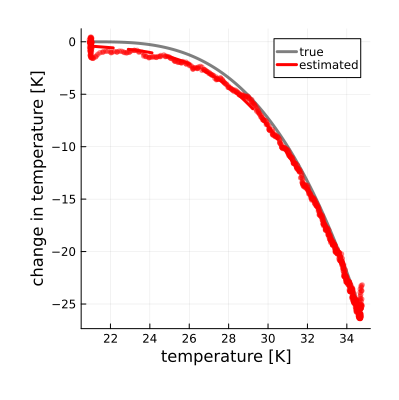

In [397]:
plot(xlabel="temperature [K]",
     ylabel="change in temperature [K]",
     # yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     # ylims=(-1000,0)
     size=(400,400),
     )
plot!(states[1,:], r.(states[1,:],1,true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[1,:], samples_f1', alpha=0.05, markerstrokewidth=0, markersize=3, color="red")
scatter!(fitx_m[1,:], fitx_m[4,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="red")
plot!(sort(fitx_m[1,:]), x -> f1_pol3(x), color="red", linestyle=:dash, label="estimated")

In [404]:
f2_pol3 = Polynomials.fit(fitx_m[2,:], fitx_m[5,:], deg, weights=fitx_v[5,:])

Polynomial(43.26104020917253 - 7.672191790369823*x + 0.4237958484533317*x^2 - 0.007457274416541849*x^3)

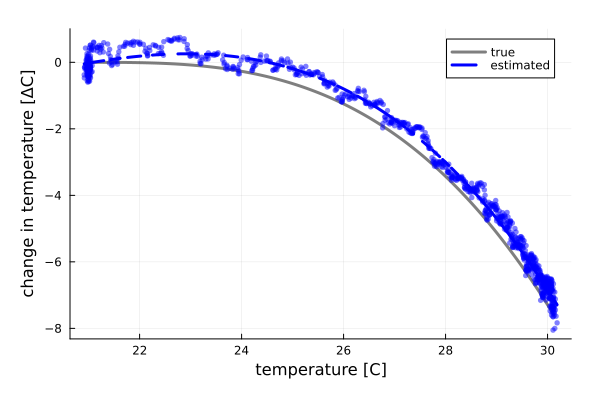

In [406]:
plot(xlabel="temperature [C]",
     ylabel="change in temperature [ΔC]",
     # yticks=(range(-250,stop=50., length=4), round.(range(-250,stop=50., length=4).*Δt./true_mcp_2, digits=2)),
     # ylims=(-250,50),
     )
plot!(states[2,:], r.(states[2,:],2,true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[2,:], samples_f2', alpha=0.05, markerstrokewidth=0, markersize=3, color="blue")
scatter!(fitx_m[2,:], fitx_m[5,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="blue")
plot!(fitx_m[2,:], x -> f2_pol3(x), color="blue", linestyle=:dash, label="estimated")

In [407]:
f3_pol3 = Polynomials.fit(fitx_m[3,:], fitx_m[6,:], deg, weights=fitx_v[6,:])

Polynomial(277.9655023781081 - 36.54374914219247*x + 1.602809317612862*x^2 - 0.023467775609853112*x^3)

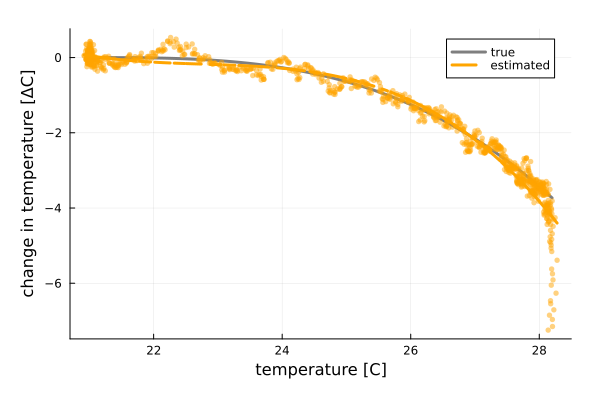

In [408]:
plot(xlabel="temperature [C]",
     ylabel="change in temperature [ΔC]",
     # yticks=(range(-60,stop=0., length=4), round.(range(-60,stop=0, length=4).*Δt./true_mcp_3, digits=2)),
     # ylims=(-60, 0.),
     )
plot!(states[3,:], r.(states[3,:],3,true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[3,:], samples_f3', alpha=0.05, markerstrokewidth=0, markersize=3, color="orange")
scatter!(fitx_m[3,:], fitx_m[6,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="orange")
plot!(fitx_m[3,:], x -> f3_pol3(x), color="orange", linestyle=:dash, label="estimated")

## Model validation

### Simulation with true function to generate validation data

In [409]:
N_val = 900
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 120.
t_offset_val = 600.
β = 0.5

# Generate functions
# u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
u1_val(t) = u.(t, b=true_b[1], t_on=t_onset_val, t_off=t_offset_val, i=1, β1=β)
u2_val(t) = u.(t, b=true_b[2], t_on=t_onset_val, t_off=t_offset_val, i=2, β1=β)
u3_val(t) = u.(t, b=true_b[3], t_on=t_onset_val, t_off=t_offset_val, i=3, β1=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×900 Matrix{Float64}:
 8.75651e-25  1.4437e-24  2.38027e-24  …  1.70647e-50  1.14388e-50
 0.0          0.0         0.0             0.0          0.0
 0.0          0.0         0.0             0.0          0.0

In [410]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) ./ mcp_1
    dz[2] += pred_mean_block2(z[2]) ./ mcp_2
    dz[3] += pred_mean_block3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [411]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [25., 25., 25.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×900 Matrix{Float64}:
 24.9878  24.9719  25.0004  24.9826  …  25.5701  25.5708  25.54    25.5143
 25.0275  24.972   24.9927  24.9441     25.4635  25.5105  25.4904  25.4925
 25.0224  24.9862  25.0307  24.9795     25.3635  25.537   25.3845  25.4065

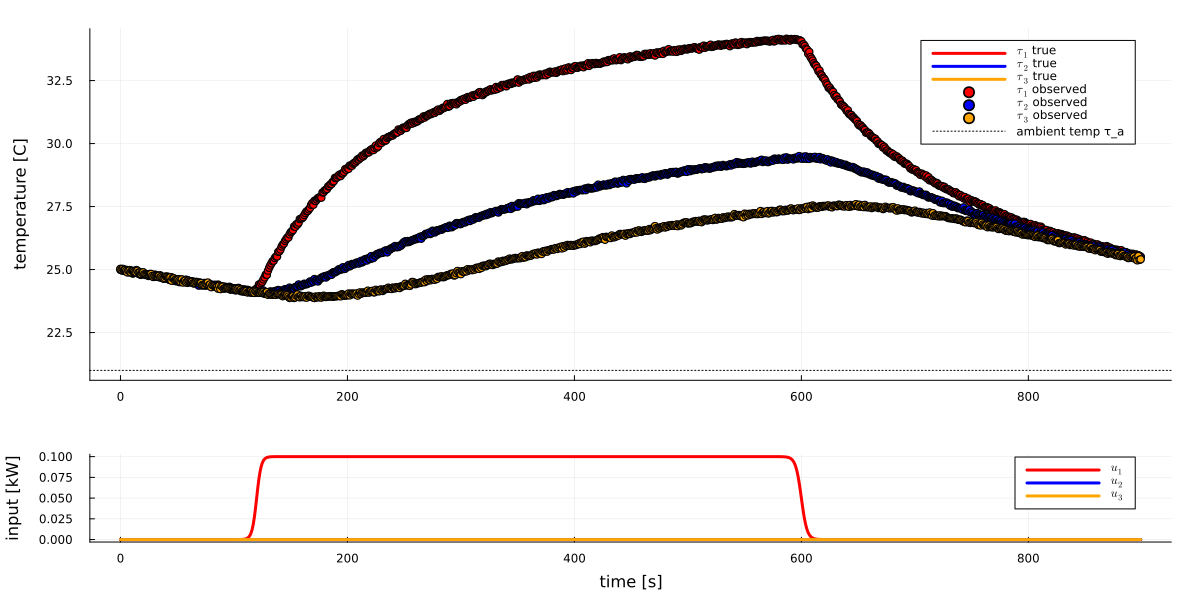

In [412]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [413]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) ./ mcp_1
    dz[2] += f2_pol3(z[2]) ./ mcp_2
    dz[3] += f3_pol3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, Tsit5(); saveat=tsteps_val, verbose = true))

3×900 Matrix{Float64}:
 25.0  24.9906  24.9812  24.9718  …  25.5208  25.51    25.4992  25.4884
 25.0  24.9918  24.9836  24.9754     25.5146  25.5046  25.4947  25.4848
 25.0  24.9915  24.9829  24.9744     25.4586  25.4495  25.4404  25.4313

### Compare true and identified 

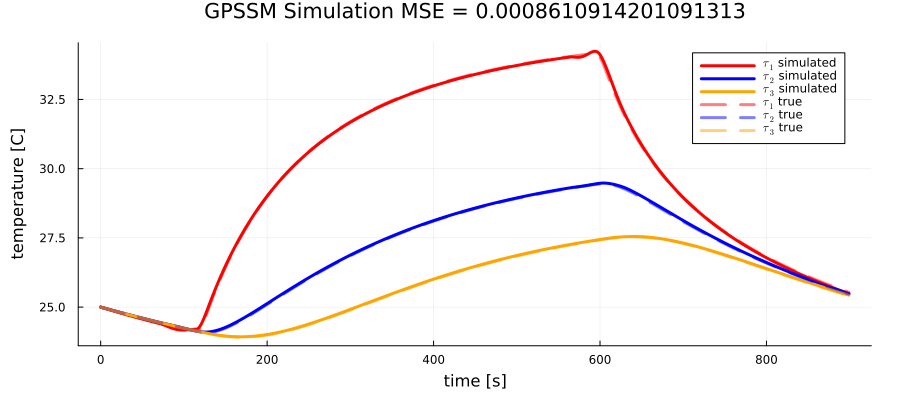

In [414]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


In [416]:
jldsave("results/LGPASSM.jld2"; true_mcp_1, true_mcp_2, true_mcp_3, true_τ_a, tsteps, Δt, fitx_m, fitx_v, states, measurements, inputs, f1_pol3, f2_pol3, f3_pol3, l_star, γ_star, tsteps_val, sim_states, states_val)